In [101]:
#pip install mca

In [2]:
import mca
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold

In [4]:
APK = pd.read_csv("./Stations/APK.csv")
GBG = pd.read_csv("./Stations/GBG.csv")
CLH = pd.read_csv("./Stations/CLH.csv", low_memory=False)
MP = pd.read_csv("./Stations/MP.csv")

rer = pd.concat([APK, GBG, CLH, MP], ignore_index=True)

# Cleaning again

In [7]:
rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'], format='%Y-%m-%d %H:%M:%S')

rer = rer.sort_values(by='stop_name', ascending=True)
rer['stop_name'] = pd.factorize(rer["stop_name"])[0]
rer['destination_name'] = pd.factorize(rer["destination_name"])[0]

#rer = rer.sort_values(by='ArRTown', ascending=True)
#rer['ArRTown'] = pd.factorize(rer["ArRTown"])[0]

rer = rer.sort_values(by='nearest_datetime', ascending=True)

rer["departure_status"] = rer["departure_status"].astype("string")
rer["is_day"] = rer["is_day"].astype(int)

In [9]:
rer['pourc_validations'] = rer['pourc_validations'].fillna(0)

In [11]:
rer.loc[rer['scheduled_arrival'].dt.month == 1, 'E10'] = 1.76
rer.loc[rer['scheduled_arrival'].dt.month == 1, '95'] = 1.79
rer.loc[rer['scheduled_arrival'].dt.month == 1, '98'] = 1.87
rer.loc[rer['scheduled_arrival'].dt.month == 1, 'gazole'] = 1.7

rer['scheduled_arrival'] = rer['scheduled_arrival'].fillna(rer['scheduled_departure'])

In [13]:
rer = rer.drop(["timestamp", "ArRTown", "real_departure", "nearest_datetime", "scheduled_departure", "Période", "real_arrival", "arrival_difference", "departure_difference", "Date", "day_type", "is_bank_holiday", "is_weekend"], axis=1)

In [15]:
rer_learn = rer
rer_test = rer

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2025-01-12 23:59:59')

start_date2 = pd.to_datetime('2025-01-13 00:00:00')
end_date2 = pd.to_datetime('2025-01-19 23:59:59')

rer_learn = rer_learn[(rer_learn['scheduled_arrival'] >= start_date) & (rer_learn['scheduled_arrival'] <= end_date)]
rer_test = rer_test[(rer_test['scheduled_arrival'] >= start_date2) & (rer_test['scheduled_arrival'] <= end_date2)]


# Summary Statistics

/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_8548/3439559554.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rer['hour'] = rer['scheduled_arrival'].dt.hour
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:149

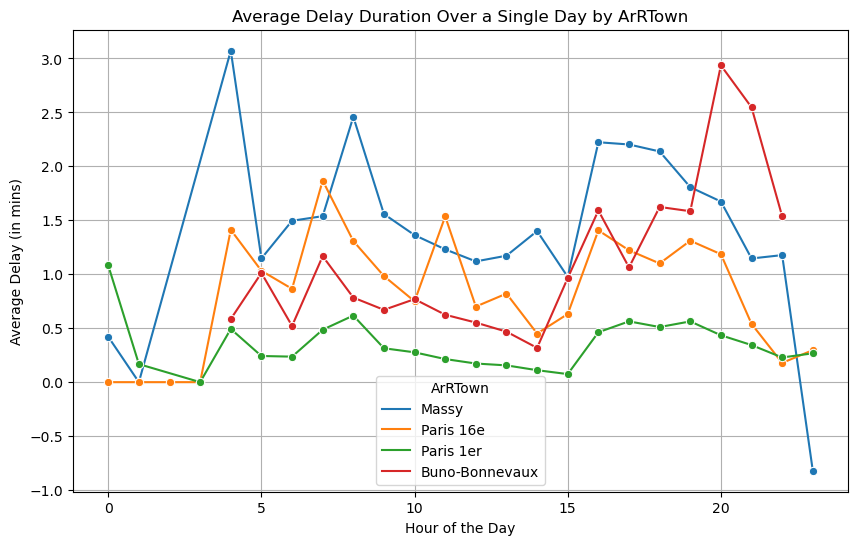

In [362]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure datetime format
rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'])

rer = rer[rer['arrival_difference'] <= 150]

# Extract hour from the scheduled arrival time
rer['hour'] = rer['scheduled_arrival'].dt.hour

# Group by 'hour' and 'ArRTown' to calculate mean delay
average_delay_by_category = rer.groupby(['hour', 'ArRTown'])['arrival_difference'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_category,
    x='hour',
    y='arrival_difference',
    hue='ArRTown',
    marker="o"
)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Delay (in mins)')
plt.title('Average Delay Duration Over a Single Day by ArRTown')
plt.legend(title="ArRTown")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-ArRTown.png", format='png', dpi=300)
plt.show()


/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_8548/3512781584.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'])
/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_8548/3512781584.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rer_filtered['day_of_week'] = rer_filtered['scheduled_arrival'].dt.dayofweek
/var/folders/zs/vj5m58vj3339k9xrxfgmwjz40000gn/T/ipykernel_8548/3512781584.py:16: SettingWithCopyWarning: 
A val

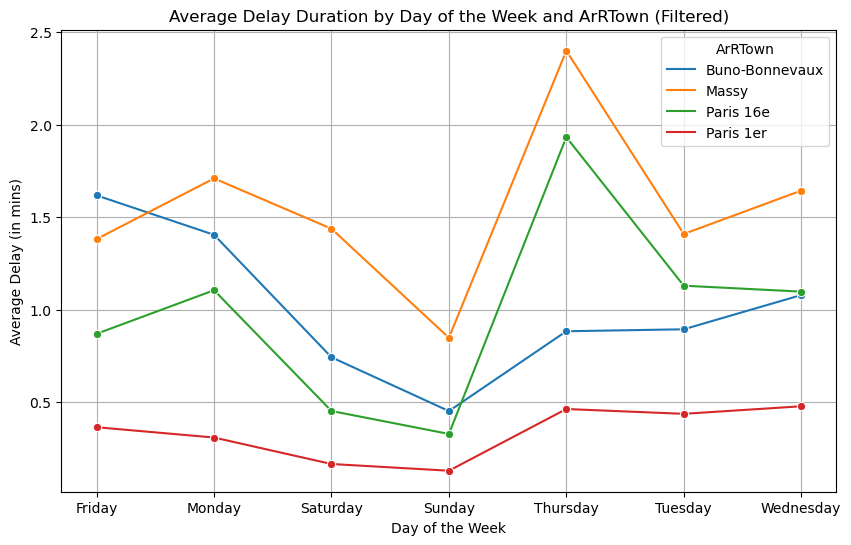

In [364]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure datetime format
rer['scheduled_arrival'] = pd.to_datetime(rer['scheduled_arrival'])

# Remove outliers where delay exceeds 100 seconds
rer_filtered = rer[rer['arrival_difference'] <= 100]

# Extract the day of the week (0 = Monday, 6 = Sunday)
rer_filtered['day_of_week'] = rer_filtered['scheduled_arrival'].dt.dayofweek

# Map numeric day of week to names for better readability
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
rer_filtered['day_of_week'] = rer_filtered['day_of_week'].map(day_names)

# Group by 'day_of_week' and 'ArRTown' to calculate mean delay
average_delay_by_day = rer_filtered.groupby(['day_of_week', 'ArRTown'])['arrival_difference'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=average_delay_by_day,
    x='day_of_week',
    y='arrival_difference',
    hue='ArRTown',
    marker="o"
)
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (in mins)')
plt.title('Average Delay Duration by Day of the Week and ArRTown (Filtered)')
plt.legend(title="ArRTown")
plt.grid(True)
plt.savefig("./Figures/Average-Delay-DayOfWeek-ArRTown.png", format='png', dpi=300)
plt.show()


# PCA

In [427]:
# Select numerical variables
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the numerical variables
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

In [429]:
# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Output the PCA results and explained variance
print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

Explained Variance Ratio: [0.21958838 0.20190111 0.13329036 0.10182305 0.09368244 0.07615144
 0.0590339  0.04749799 0.03954581 0.01990071 0.00362252 0.0027514
 0.0012109 ]
PCA DataFrame Head:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.136439  1.031619  1.179635 -0.779641  0.962838 -0.103913  5.262836   
1  3.128144  1.040497  1.165919 -0.799500  0.988114  0.115399  5.272590   
2  3.136439  1.031619  1.179635 -0.779641  0.962838 -0.103913  5.262836   
3  3.128144  1.040497  1.165919 -0.799500  0.988114  0.115399  5.272590   
4  3.136439  1.031619  1.179635 -0.779641  0.962838 -0.103913  5.262836   

        PC8       PC9      PC10      PC11      PC12      PC13  
0  0.306390  0.099832  0.318333 -0.102640  0.021590  0.002409  
1  0.287887  0.100366  0.312983 -0.101592  0.022258  0.003825  
2  0.306390  0.099832  0.318333 -0.102640  0.021590  0.002409  
3  0.287887  0.100366  0.312983 -0.101592  0.022258  0.003825  
4  0.306390  0.099832  0.318333 -0.1

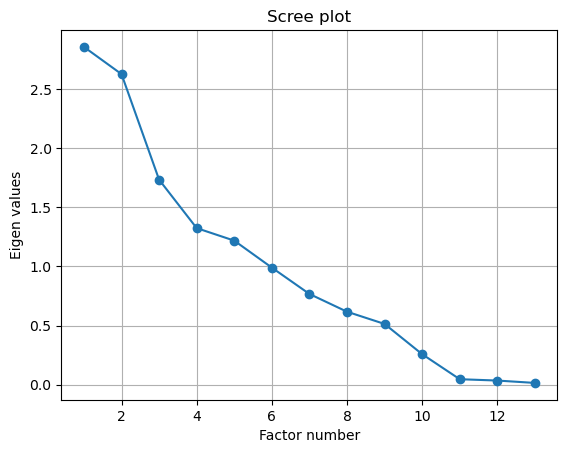

In [433]:
# -or
# Assuming you already have your dataset loaded into 'APK' DataFrame and it's preprocessed

# Select numerical columns
numerical_vars = metro_learn.select_dtypes(include=['float64'])

# Standardize the data
scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

# Perform PCA
pca = PCA()
pca.fit(numerical_vars_scaled)

# Eigenvalues (explained variance for each principal component)
eigval = pca.explained_variance_

# Number of components (k)
k = len(eigval)

# Scree plot
plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot.png', bbox_inches='tight', dpi=300)
plt.show()


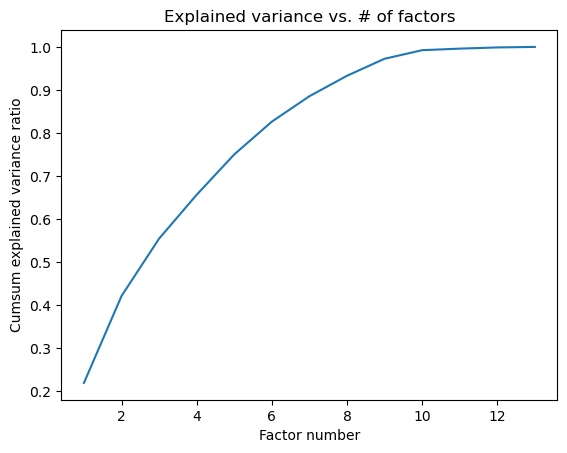

In [435]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot.png', bbox_inches='tight', dpi=300)
plt.show()

In [255]:
## 5 factors picked for expainability

In [258]:
eigval

array([2.62727289, 1.95070558, 1.20435089, 1.00108053, 0.61416811,
       0.53790141, 0.05368962, 0.01188291])

In [202]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.32883105 0.56766075 0.72139829 0.84537821 0.92350753 0.99134853
 0.99803734 1.        ]


# MCA - to do

In [153]:
# Assuming APK_learn is your DataFrame, and categorical columns are encoded as integers
# Select columns that are of integer type (numerical encoded categorical columns)
categorical_columns = APK_learn.select_dtypes(include=['int64']).columns

# Run MCA using the mca library, specifying n_components for multiple components
mca_model = mca.MCA(APK_learn[categorical_columns], ncols=7)  # Request 7 components

# Access the MCA results (coordinates of the data points in the reduced space)
mca_results = mca_model.fs_r()  # Call the function to get the result

# Create a DataFrame with the MCA results
mca_df = pd.DataFrame(mca_results, columns=[f'MCA{i+1}' for i in range(mca_results.shape[1])])

# Display the first few rows of the MCA results
print(mca_df.head())


       MCA1
0  0.090216
1  0.158122
2  0.119318
3  0.158122
4  0.090216


In [ ]:
# Optionally, you can plot the first two components (MCA1 vs MCA2)
plt.figure(figsize=(10, 6))
plt.scatter(mca_df['MCA1'], mca_df['MCA2'], alpha=0.5)
plt.title('MCA: First Two Components')
plt.xlabel('MCA1')
plt.ylabel('MCA2')
plt.grid(True)
plt.show()

# Random Forest

In [17]:
rer.dtypes

stop_name                              int64
destination_name                       int64
departure_status              string[python]
scheduled_arrival             datetime64[ns]
95                                   float64
98                                   float64
E10                                  float64
gazole                               float64
temperature_2m                       float64
precipitation                        float64
rain                                 float64
snowfall                             float64
wind_speed_10m                       float64
wind_gusts_10m                       float64
visibility                           float64
is_day                                 int64
day_of_week                            int64
is_holiday                             int64
saturday                               int64
sunday                                 int64
is_weekend_or_bank_holiday             int64
pourc_validations                    float64
dtype: obj

In [19]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(rer_learn)) 

There are 4 columns that have missing values.
        Missing Values  % of Total Values
95                   2                0.0
98                   2                0.0
E10                  2                0.0
gazole               2                0.0


### include standardised float cols - unfinished

# prediction

In [403]:
#APK_learn = APK_learn.drop(["scheduled_arrival"], axis=1)
#APK_learn["scheduled_arrival"] = APK_learn["scheduled_arrival"].astype(object)
# Convert datetime to numeric timestamp
#APK_learn['scheduled_arrival_numeric'] = APK_learn['scheduled_arrival'].apply(lambda x: x.timestamp())

In [21]:
rer_learn = rer_learn.copy()
rer_learn.loc[:, 'scheduled_arrival' + '_year'] = rer_learn['scheduled_arrival'].dt.year
rer_learn.loc[:, 'scheduled_arrival' + '_month'] = rer_learn['scheduled_arrival'].dt.month
rer_learn.loc[:, 'scheduled_arrival' + '_day'] = rer_learn['scheduled_arrival'].dt.day
rer_learn.loc[:, 'scheduled_arrival' + '_hour'] = rer_learn['scheduled_arrival'].dt.hour
rer_learn.loc[:, 'scheduled_arrival' + '_minute'] = rer_learn['scheduled_arrival'].dt.minute
rer_learn.loc[:, 'scheduled_arrival' + '_second'] = rer_learn['scheduled_arrival'].dt.second

rer_test = rer_test.copy()
rer_test.loc[:, 'scheduled_arrival' + '_year'] = rer_test['scheduled_arrival'].dt.year
rer_test.loc[:, 'scheduled_arrival' + '_month'] = rer_test['scheduled_arrival'].dt.month
rer_test.loc[:, 'scheduled_arrival' + '_day'] = rer_test['scheduled_arrival'].dt.day
rer_test.loc[:, 'scheduled_arrival' + '_hour'] = rer_test['scheduled_arrival'].dt.hour
rer_test.loc[:, 'scheduled_arrival' + '_minute'] = rer_test['scheduled_arrival'].dt.minute
rer_test.loc[:, 'scheduled_arrival' + '_second'] = rer_test['scheduled_arrival'].dt.second

In [23]:
rer_learn.drop(['scheduled_arrival'], axis=1, inplace=True)  # Drop the original datetime column if not needed
rer_test.drop(['scheduled_arrival'], axis=1, inplace=True)  # Drop the original datetime column if not needed

In [25]:
#APK_learn = APK_learn[['scheduled_arrival_numeric'] + [col for col in APK_learn.columns if col != 'scheduled_arrival_numeric']]

In [27]:
# Assuming APK_learn is your DataFrame
# Extract the explanatory variables and the target variable
rer_learn_X = rer_learn.drop('departure_status', axis=1)  # Features (exclude target)
rer_learn_Y = rer_learn['departure_status']  # Target variable

# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(rer_learn_X, 
                                                    rer_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=rer_learn_Y)


In [29]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [31]:
# Perform GridSearchCV with StratifiedKFold cross-validation
cv_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='accuracy')

In [33]:
rf_cv.fit(X_train, Y_train)
best_model = rf_cv.best_estimator_

# Output the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {rf_cv.best_params_}")

/opt/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}


In [34]:
rer_test_X = rer_test.drop('departure_status', axis=1)  # Features (exclude target)
rer_test_Y = rer_test['departure_status']  # Target variable


In [35]:
# Evaluate the model on the test set
y_pred_train = best_model.predict(X_test)
y_pred_test = best_model.predict(rer_test_X)

# Print the accuracy on training and test sets
print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(rer_test_Y, y_pred_test):.4f}")

# Create DataFrames for plotting prediction vs true values
train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': rer_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9443
Test Accuracy: 0.9233


In [36]:
# Assuming 'PRIMARY_KEY' is a column in your test set
# Create a DataFrame with PRIMARY_KEY and predicted target values
predictions_df = pd.DataFrame({
    'datetime': rer_test_X[['scheduled_arrival_year', 'scheduled_arrival_month', 'scheduled_arrival_day', 
                           'scheduled_arrival_hour', 'scheduled_arrival_minute', 'scheduled_arrival_second']].apply(
                            lambda row: '-'.join(row.astype(str)), axis=1),  # Combine as a single key
    'target': y_pred_test
})


# Save the predictions to a CSV file
predictions_df.to_csv('sigh.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation


In [37]:
rer_pred = pd.read_csv("sigh.csv")

In [38]:
# Generate confusion matrix
conf_matrix = confusion_matrix(rer_test_Y, y_pred_test)
print(conf_matrix)


[[   0    0  102]
 [   0    0  382]
 [   0    0 5826]]


In [39]:
rer_test['departure_status'].value_counts()

departure_status
onTime       5826
delayed       382
cancelled     102
Name: count, dtype: Int64

# idk what this is

In [523]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming APK_learn is your DataFrame
# Extract the explanatory variables and the target variable
APK_learn_X = rer_learn.drop('departure_status', axis=1)  # Features (exclude target)
APK_learn_Y = rer_learn[['departure_status']]  # Target variable

# Train-test split (80-20 split)
X_train, X_test, Y_train, Y_test = train_test_split(APK_learn_X, 
                                                    APK_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=APK_learn_Y)

In [525]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Define the parameter grid for GridSearchCV
rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [527]:
# Perform GridSearchCV with StratifiedKFold cross-validation
cv_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='accuracy')
rf_cv.fit(X_train, Y_train)

# Output the best hyperparameters found by GridSearchCV
print(f"Best hyperparameters: {rf_cv.best_params_}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
y_pred_train = rf_cv.predict(X_train)
y_pred_test = rf_cv.predict(X_test)

# Print the accuracy on training and test sets
print(f"Training Accuracy: {accuracy_score(Y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred_test):.4f}")

# Create DataFrames for plotting prediction vs true values
train_pred_vs_true = pd.DataFrame({'True': Y_train['departure_status'], 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': Y_test['departure_status'], 
                                  'Predicted': y_pred_test})

# Plotting prediction vs true values for train set
sns.scatterplot(data=train_pred_vs_true, x='True', y='Predicted', alpha=0.5)
plt.title("Train: Prediction vs True Values")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Plotting prediction vs true values for test set
sns.scatterplot(data=test_pred_vs_true, x='True', y='Predicted', alpha=0.5)
plt.title("Test: Prediction vs True Values")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()